<a href="https://colab.research.google.com/github/Stalinosmj/Unet/blob/master/Unet_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics
!pip install torchinfo
!pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
!wget "https://datasets.simula.no/downloads/kvasir-seg.zip"
!unzip /content/kvasir-seg.zip

--2025-05-30 18:14:49--  https://datasets.simula.no/downloads/kvasir-seg.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46227172 (44M) [application/zip]
Saving to: ‘kvasir-seg.zip’

kvasir-seg.zip      100%[===================>]  44.08M  14.6MB/s    in 3.0s    

2025-05-30 18:14:53 (14.6 MB/s) - ‘kvasir-seg.zip’ saved [46227172/46227172]

Archive:  /content/kvasir-seg.zip
   creating: Kvasir-SEG/
  inflating: Kvasir-SEG/kavsir_bboxes.json  
   creating: Kvasir-SEG/images/
  inflating: Kvasir-SEG/images/ck2bxiswtxuw80838qkisqjwz.jpg  
  inflating: Kvasir-SEG/images/ck2bxknhjvs1x0794iogrq49k.jpg  
  inflating: Kvasir-SEG/images/ck2bxlujamu330725szlc2jdu.jpg  
  inflating: Kvasir-SEG/images/ck2bxpfgxu2mk0748gsh7xelu.jpg  
  inflating: Kvasir-SEG/images/ck2bxqz3evvg20794iiyv5v2m.jpg  
  inflating: Kvasir-SEG/images/ck2bxskgxxzfv

# Import necessary libraries

In [3]:
import os
import cv2
import json
import glob
import torch
import numpy as np
import torchmetrics
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models
import torchmetrics.functional as TMF
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [4]:
print("PyTorch Version: ", torch.__version__)

PyTorch Version:  2.6.0+cu124


In [5]:
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Global constants

In [6]:
IMAGE_SIZE = 256
EPOCHS = 30
BATCH = 8
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = "/content/Kvasir-SEG/"

# Loading and splitting of Data

In [11]:
def load_data(path, split=0.1):
    images = sorted(glob.glob(os.path.join(path, "images", "*")))
    masks = sorted(glob.glob(os.path.join(path, "masks", "*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [12]:
# Load bounding boxes
with open("/content/Kvasir-SEG/kavsir_bboxes.json", "r") as file:
    bbox_data = json.load(file)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

    # Get bounding box for this image
    image_name = path.split("/")[-1]
    bbox = bbox_data.get(image_name)

    if bbox:
        x, y, w, h = bbox
        x = x[y:y+h, x:x+w]

    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x.astype(np.float32) / 255.0
    x = torch.from_numpy(x).permute(2, 0, 1)
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    image_name = path.split("/")[-1]
    bbox = bbox_data.get(image_name)

    if bbox:
        x, y, w, h = bbox
        x = x[y:y+h, x:x+w]

    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x.astype(np.float32) / 255.0
    x = torch.from_numpy(x).unsqueeze(0)
    return x

In [13]:
class SegmentationDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = read_image(self.images[idx])
        mask = read_mask(self.masks[idx])
        return image, mask

# Function to create DataLoader
def get_dataloader(images, masks, batch_size=8, shuffle=True):
    dataset = SegmentationDataset(images, masks)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [14]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(DATA_PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  800
Validation data:  100
Testing data:  100


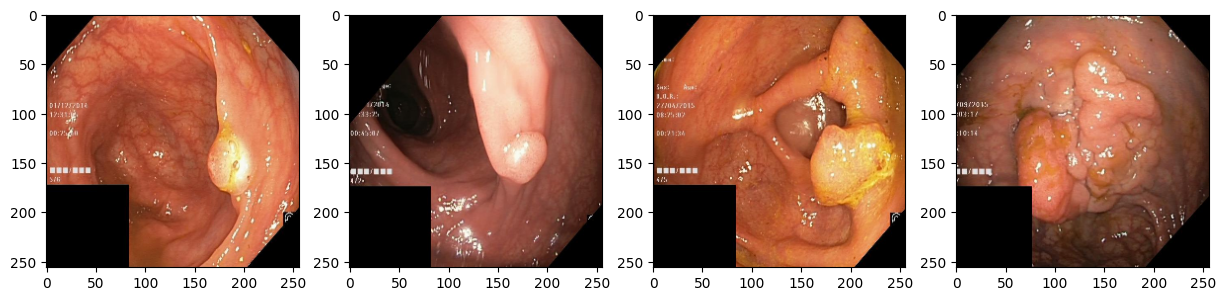

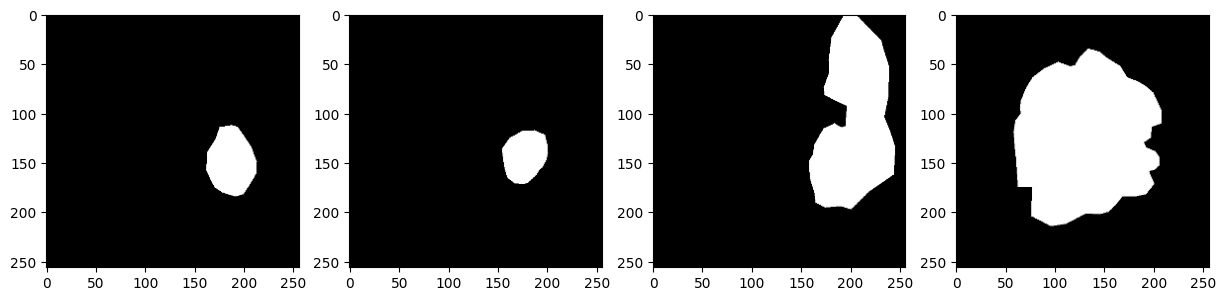

In [15]:
fig = plt.figure(figsize=(15, 15))

for i in range(4):
    a = fig.add_subplot(1, 4, i + 1)
    imgplot = plt.imshow(read_image(train_x[i]).permute(1, 2, 0).numpy())
    imgplot.set_clim(0.0, 0.7 * (i + 1))

fig = plt.figure(figsize=(15, 15))

for i in range(4):
    a = fig.add_subplot(1, 4, i + 1)
    imgplot = plt.imshow(read_mask(train_y[i]).squeeze().cpu().numpy(), cmap="gray")


#U-Net Architecture






In [16]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder (downsampling)
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder (upsampling)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        # Final layer
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        self.activation = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder (downsampling)
        enc1_out = self.enc1(x)
        enc2_out = self.enc2(F.max_pool2d(enc1_out, 2))
        enc3_out = self.enc3(F.max_pool2d(enc2_out, 2))
        enc4_out = self.enc4(F.max_pool2d(enc3_out, 2))

        # Bottleneck
        bottleneck_out = self.bottleneck(F.max_pool2d(enc4_out, 2))

        # Decoder (upsampling)
        up4 = self.upconv4(bottleneck_out)
        up4 = torch.cat([up4, enc4_out], dim=1)
        up4 = self.dec4(up4)

        up3 = self.upconv3(up4)
        up3 = torch.cat([up3, enc3_out], dim=1)
        up3 = self.dec3(up3)

        up2 = self.upconv2(up3)
        up2 = torch.cat([up2, enc2_out], dim=1)
        up2 = self.dec2(up2)

        up1 = self.upconv1(up2)
        up1 = torch.cat([up1, enc1_out], dim=1)
        up1 = self.dec1(up1)

        return self.activation(self.final_conv(up1))

# Instantiate model
model = UNet().to("cuda")

#Model Summary

In [17]:
# Print model architecture
print(model)

# Display detailed summary
summary(model, input_size=(1, 3, IMAGE_SIZE, IMAGE_SIZE))

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 256, 256]          --
├─Sequential: 1-1                        [1, 64, 256, 256]         --
│    └─Conv2d: 2-1                       [1, 64, 256, 256]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 256, 256]         128
│    └─ReLU: 2-3                         [1, 64, 256, 256]         --
│    └─Conv2d: 2-4                       [1, 64, 256, 256]         36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 256, 256]         128
│    └─ReLU: 2-6                         [1, 64, 256, 256]         --
├─Sequential: 1-2                        [1, 128, 128, 128]        --
│    └─Conv2d: 2-7                       [1, 128, 128, 128]        73,856
│    └─BatchNorm2d: 2-8                  [1, 128, 128, 128]        256
│    └─ReLU: 2-9                         [1, 128, 128, 128]        --
│    └─Conv2d: 2-10                      [1, 128, 128, 128]        147,

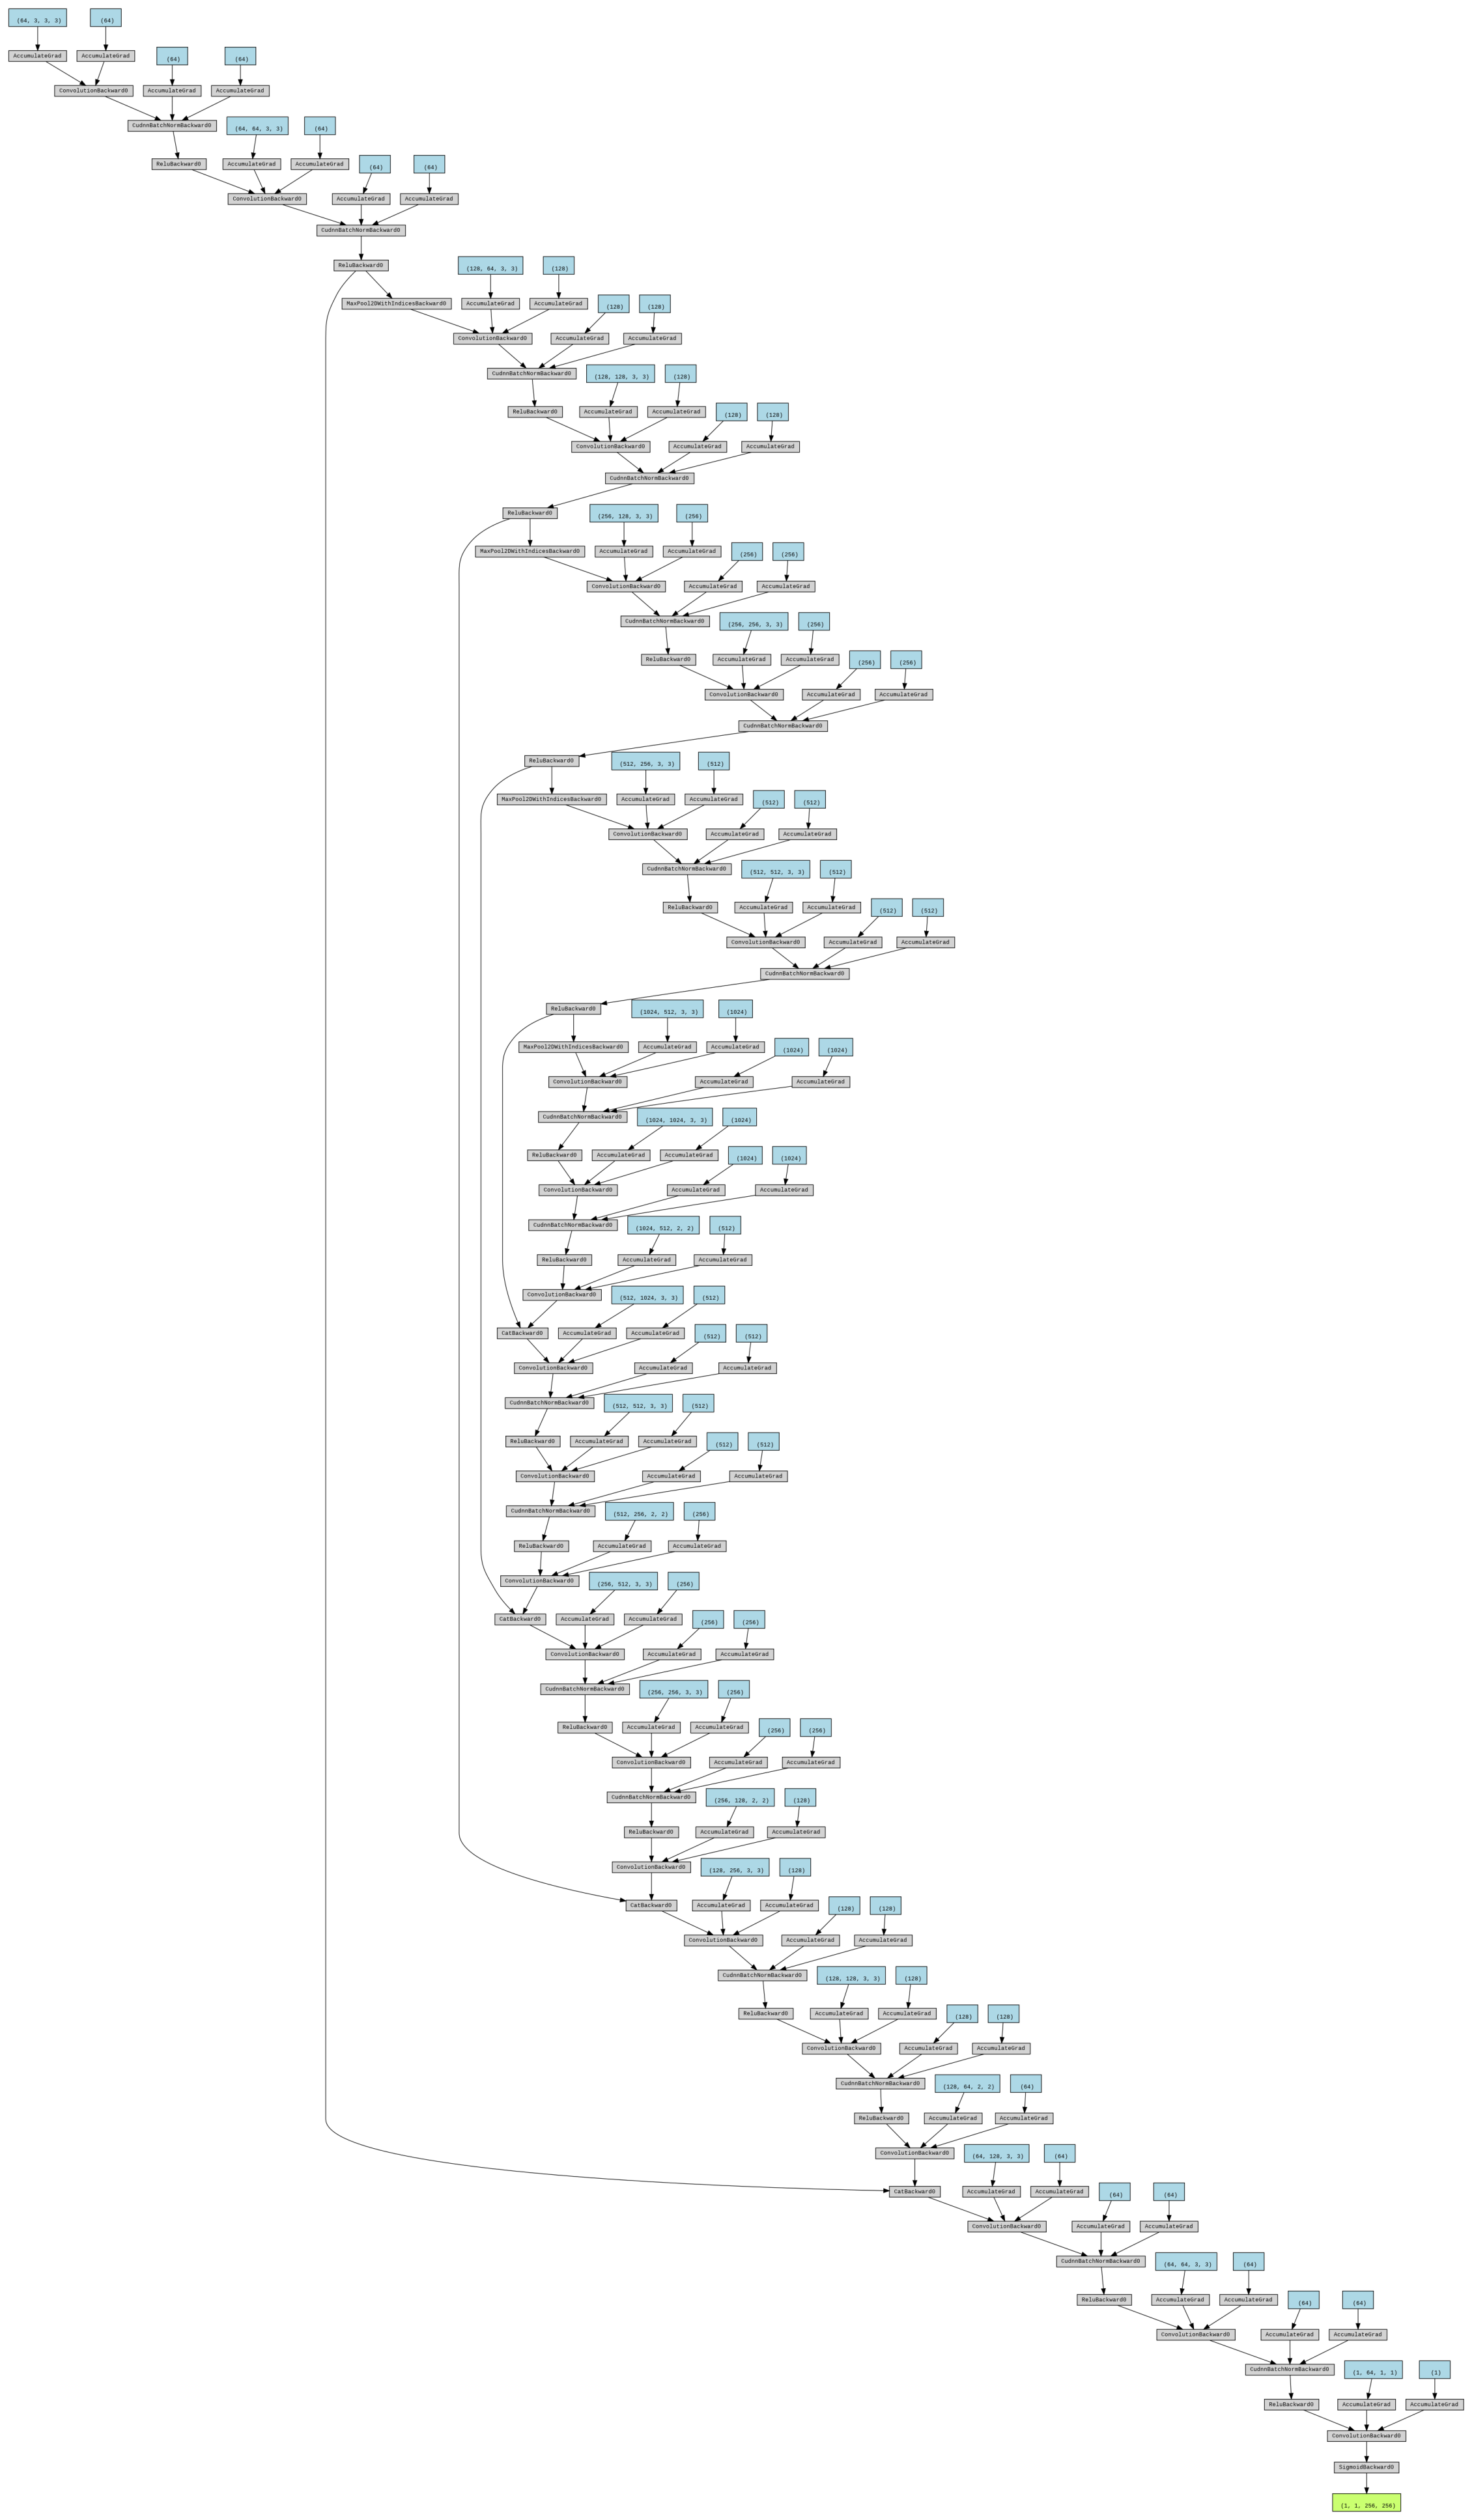

In [18]:
from torchviz import make_dot

input_tensor = torch.randn(1, 3, 256, 256).to("cuda")

make_dot(model(input_tensor)).render("model_graph", format="png")


img = cv2.imread("/content/model_graph.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(50, 50))
plt.imshow(img)
plt.axis("off")
plt.show()

#Dice Coefficient and Loss Functions

In [46]:
smooth = 1e-6

def dice_coef(y_true, y_pred):
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    intersection = torch.sum(y_true * y_pred)
    dice = (2. * intersection + smooth) / (torch.sum(y_true) + torch.sum(y_pred) + smooth)

    return dice


def iou_score(y_true, y_pred):
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred) - intersection

    return (intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


def combined_loss(y_true, y_pred, alpha=0.5):
    dice = dice_loss(y_true, y_pred)
    iou = 1.0 - iou_score(y_true, y_pred)

    return alpha * dice + (1 - alpha) * iou  # Weighted combination of Dice and IoU losses

In [47]:
train_dataset = SegmentationDataset(train_x, train_y)
valid_dataset = SegmentationDataset(valid_x, valid_y)

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH, shuffle=False)


In [48]:
# Define optimizer
optimizer = optim.NAdam(model.parameters(), lr=LR)

# Define loss function
criterion = dice_loss

# Define metrics using torchmetrics
precision_metric = torchmetrics.Precision(task = "binary")
recall_metric = torchmetrics.Recall(task = "binary")

# For usage in training loop
def calculate_metrics(y_true, y_pred):
    dice = dice_coef(y_true, y_pred)
    precision = precision_metric(y_pred, y_true)
    recall = recall_metric(y_pred, y_true)
    return dice, precision, recall

In [49]:
# Learning rate scheduler (ReduceLROnPlateau equivalent)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4)

# Early stopping implementation
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0, restore_best_weights=False):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = float('inf')
        self.counter = 0
        self.best_model_state = None

    def check_early_stop(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_model_state = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered.")
                if self.restore_best_weights and self.best_model_state:
                    model.load_state_dict(self.best_model_state)
                return True
        return False

# Instantiate early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=False)

#Training Loop

In [50]:

# Compute Training and Validation Steps
train_steps = len(train_x) // BATCH
valid_steps = len(valid_x) // BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

train_losses, val_losses = [], []
dice_scores, iou_scores = [], []  # Track Dice and IoU over epochs


# Training Loop
for epoch in range(EPOCHS):
    model.train()
    epoch_loss, epoch_dice, epoch_iou = 0.0, 0.0, 0.0

    for step, (images, masks) in enumerate(train_loader):
        images, masks = images.to("cuda"), masks.to("cuda")

        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(masks, preds)

        loss.backward()
        optimizer.step()

        # Accumulate Metrics
        epoch_loss += loss.item()
        epoch_dice += dice_coef(masks, preds).item()
        epoch_iou += iou_score(masks, preds).item()

        if step >= train_steps:
            break

    # Compute Training Averages
    avg_train_loss = epoch_loss / train_steps
    avg_train_dice = epoch_dice / train_steps
    avg_train_iou = epoch_iou / train_steps

    # Store for visualization
    train_losses.append(avg_train_loss)
    dice_scores.append(avg_train_dice)
    iou_scores.append(avg_train_iou)

    # Validation Loop
    model.eval()
    val_loss, val_dice, val_iou = 0.0, 0.0, 0.0

    with torch.no_grad():
        for step, (images, masks) in enumerate(valid_loader):
            images, masks = images.to("cuda"), masks.to("cuda")

            preds = model(images)
            loss = criterion(masks, preds)

            val_loss += loss.item()
            val_dice += dice_coef(masks, preds).item()
            val_iou += iou_score(masks, preds).item()

            if step >= valid_steps:
                break

    # Compute Validation Averages
    avg_val_loss = val_loss / valid_steps
    avg_val_dice = val_dice / valid_steps
    avg_val_iou = val_iou / valid_steps

    # Store for visualization
    val_losses.append(avg_val_loss)

    # Print Epoch Metrics
    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {avg_train_loss:.4f}, Dice Coef: {avg_train_dice:.4f}, IoU: {avg_train_iou:.4f} - "
          f"Val Loss: {avg_val_loss:.4f}, Dice Coef: {avg_val_dice:.4f}, IoU: {avg_val_iou:.4f}")

    # Update Learning Rate
    scheduler.step(avg_val_loss)

    # Check for Early Stopping
    if early_stopping.check_early_stop(avg_val_loss, model):
        break


Epoch 1/30 - Train Loss: 0.0775, Dice Coef: 0.9225, IoU: 0.8578 - Val Loss: 0.2353, Dice Coef: 0.7647, IoU: 0.6251
Epoch 2/30 - Train Loss: 0.0825, Dice Coef: 0.9175, IoU: 0.8494 - Val Loss: 0.2187, Dice Coef: 0.7813, IoU: 0.6487
Epoch 3/30 - Train Loss: 0.0693, Dice Coef: 0.9307, IoU: 0.8723 - Val Loss: 0.2256, Dice Coef: 0.7744, IoU: 0.6384
Epoch 4/30 - Train Loss: 0.0650, Dice Coef: 0.9350, IoU: 0.8792 - Val Loss: 0.2235, Dice Coef: 0.7765, IoU: 0.6417
Epoch 5/30 - Train Loss: 0.0611, Dice Coef: 0.9389, IoU: 0.8860 - Val Loss: 0.2084, Dice Coef: 0.7916, IoU: 0.6618
Epoch 6/30 - Train Loss: 0.0690, Dice Coef: 0.9310, IoU: 0.8727 - Val Loss: 0.2060, Dice Coef: 0.7940, IoU: 0.6641
Epoch 7/30 - Train Loss: 0.0659, Dice Coef: 0.9341, IoU: 0.8776 - Val Loss: 0.2099, Dice Coef: 0.7901, IoU: 0.6592
Epoch 8/30 - Train Loss: 0.0764, Dice Coef: 0.9236, IoU: 0.8609 - Val Loss: 0.2078, Dice Coef: 0.7922, IoU: 0.6619
Epoch 9/30 - Train Loss: 0.0580, Dice Coef: 0.9420, IoU: 0.8912 - Val Loss: 0.19

#Model Evaluation on Test Set

In [51]:
# Create test dataset and loader
test_dataset = SegmentationDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
print(DEVICE)
precision_metric = torchmetrics.Precision(task="binary").to(DEVICE)
recall_metric = torchmetrics.Recall(task="binary").to(DEVICE)


# Calculate number of steps
test_steps = len(test_x) // BATCH
if len(test_x) % BATCH != 0:
    test_steps += 1

# Evaluate model on test set
model.eval()
test_loss = 0.0
test_dice = 0.0
test_precision = 0.0
test_recall = 0.0
test_iou = 0.0  # Added IoU tracking

with torch.no_grad():
    for step, (images, masks) in enumerate(test_loader):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        preds = model(images)
        loss = criterion(masks, preds)

        # Convert masks and predictions to binary
        binary_masks = (masks > 0.5).float()
        binary_preds = (preds > 0.5).float()

        test_loss += loss.item()
        test_dice += dice_coef(binary_masks, binary_preds).item()
        test_precision += precision_metric(binary_preds, binary_masks).item()
        test_recall += recall_metric(binary_preds, binary_masks).item()
        test_iou += iou_score(binary_masks, binary_preds).item()  # IoU computation

        if step >= test_steps:
            break

# Compute average metrics
avg_test_loss = test_loss / test_steps
avg_test_dice = test_dice / test_steps
avg_test_precision = test_precision / test_steps
avg_test_recall = test_recall / test_steps
avg_test_iou = test_iou / test_steps  # Average IoU

print(f"Test Loss: {avg_test_loss:.4f}, Dice Coef: {avg_test_dice:.4f}, Precision: {avg_test_precision:.4f}, "
      f"Recall: {avg_test_recall:.4f}, IoU: {avg_test_iou:.4f}")

cuda
Test Loss: 0.1895, Dice Coef: 0.8109, Precision: 0.8844, Recall: 0.7604, IoU: 0.6893


In [52]:
import plotly.graph_objects as go

# Create x-axis (Epochs)
epochs = list(range(1, EPOCHS + 1))

# Create interactive plot
fig = go.Figure()

# 🔴 Train Loss
fig.add_trace(go.Scatter(x=epochs, y=train_losses, mode='lines+markers',
                         name='Train Loss', line=dict(color='red', dash='dash')))

# 🔵 Validation Loss
fig.add_trace(go.Scatter(x=epochs, y=val_losses, mode='lines+markers',
                         name='Validation Loss', line=dict(color='blue', dash='solid')))

# 🟢 Dice Coefficient
fig.add_trace(go.Scatter(x=epochs, y=dice_scores, mode='lines+markers',
                         name='Dice Coefficient', line=dict(color='green', dash='dot')))

# 🟣 IoU Score (Ensure IoU is correctly computed during training and evaluation)
fig.add_trace(go.Scatter(x=epochs, y=iou_scores, mode='lines+markers',
                         name='IoU Score', line=dict(color='magenta', dash='dashdot')))

# 📊 Customize layout
fig.update_layout(
    title="Model Training Performance",
    xaxis_title="Epochs",
    yaxis_title="Metric Value",
    template="plotly_dark",
    legend=dict(x=0, y=1),
    width=800, height=500
)

# Show plot
fig.show()


In [53]:
# Load bounding boxes
with open("/content/Kvasir-SEG/kavsir_bboxes.json", "r") as file:
    bbox_data = json.load(file)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    if x is None:
        raise ValueError(f"Error loading image: {path}")

    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

    image_name = path.split("/")[-1]
    bbox = bbox_data.get(image_name)

    if bbox:
        x_min, y_min, width, height = bbox
        x_max, y_max = x_min + width, y_min + height

        h, w, _ = x.shape
        x_min, x_max = max(0, x_min), min(w, x_max)
        y_min, y_max = max(0, y_min), min(h, y_max)

        x = x[y_min:y_max, x_min:x_max]

    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x.astype(np.float32) / 255.0
    x = torch.from_numpy(x).permute(2, 0, 1)
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if x is None:
        raise ValueError(f"Error loading mask: {path}")

    # Get bounding box for this image
    image_name = path.split("/")[-1]
    bbox = bbox_data.get(image_name)

    if bbox:
        x_min, y_min, width, height = bbox
        x_max, y_max = x_min + width, y_min + height


        h, w = x.shape
        x_min, x_max = max(0, x_min), min(w, x_max)
        y_min, y_max = max(0, y_min), min(h, y_max)

        x = x[y_min:y_max, x_min:x_max]

    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x.astype(np.float32) / 255.0
    x = torch.from_numpy(x).unsqueeze(0)
    return x

In [54]:
def mask_parse(mask):
    mask = mask.squeeze()
    mask = torch.stack([mask, mask, mask], dim=0)
    mask = mask.permute(1, 2, 0)
    return mask

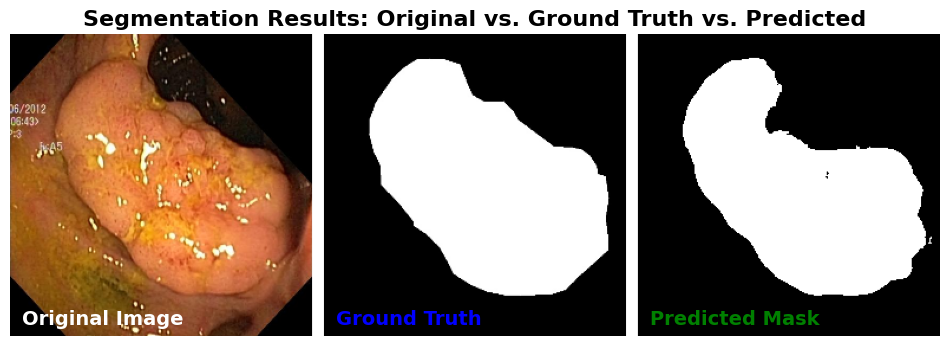

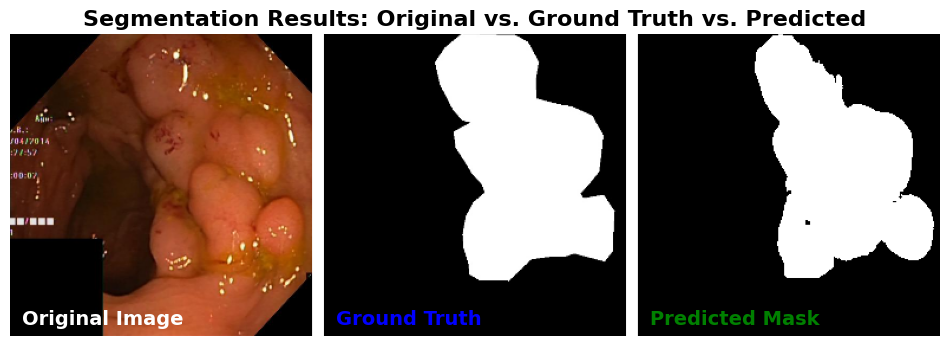

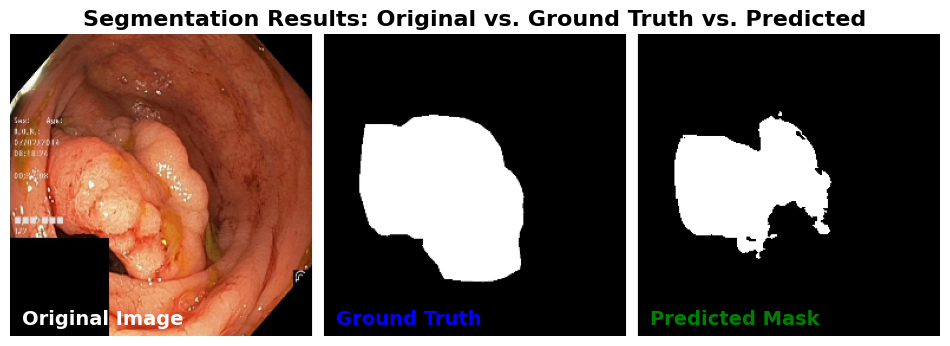

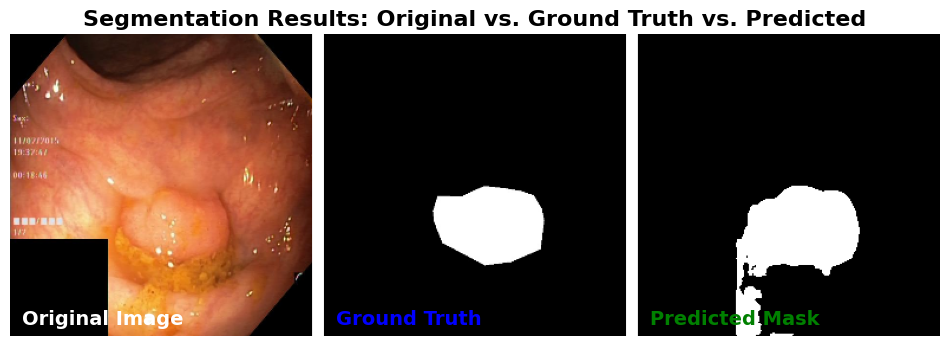

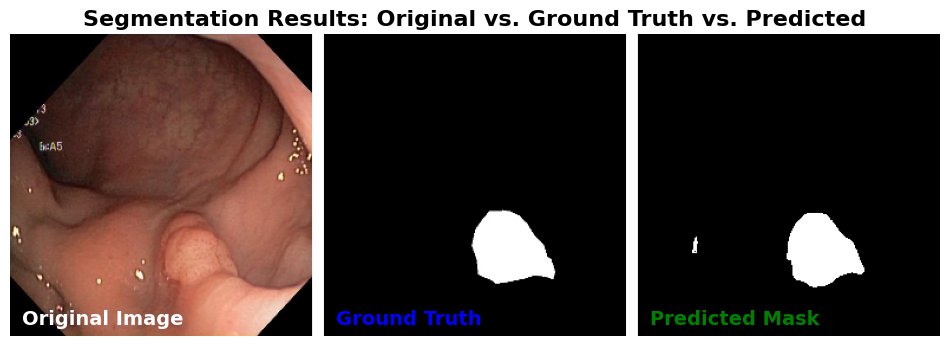

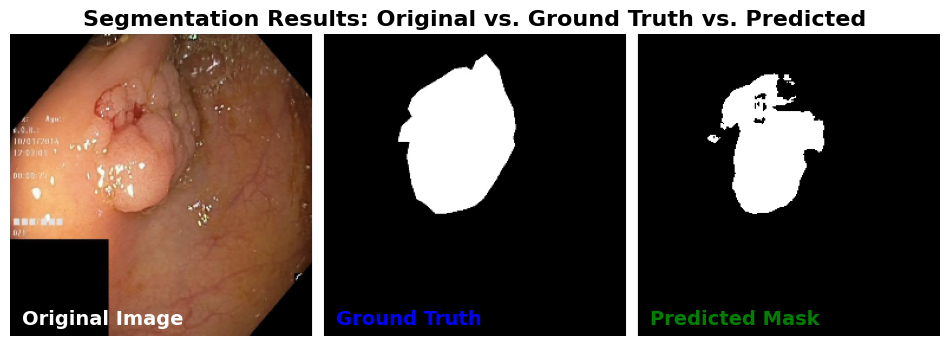

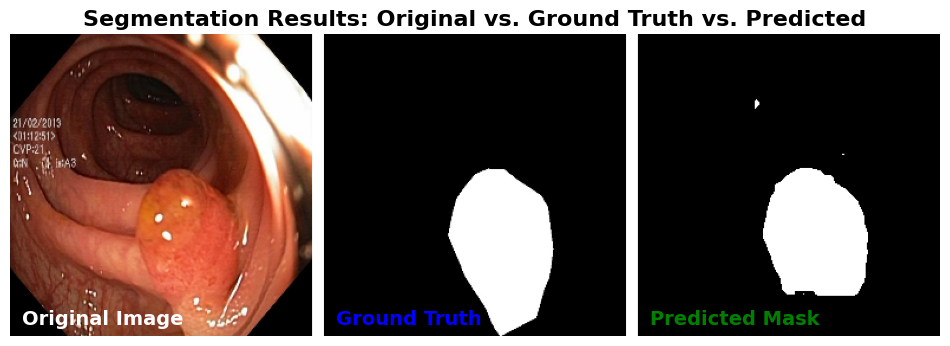

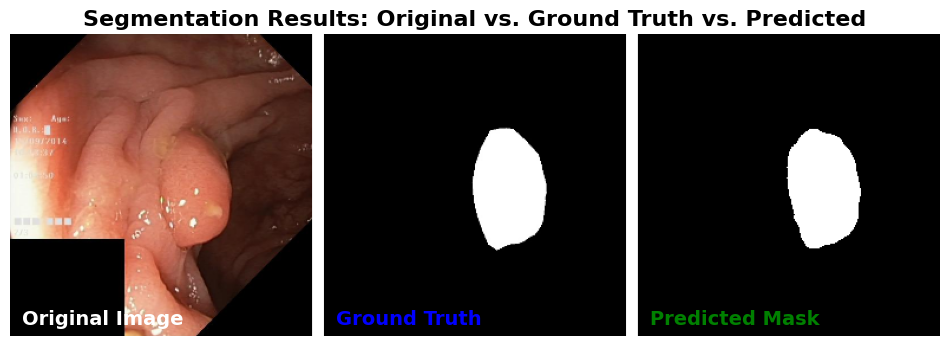

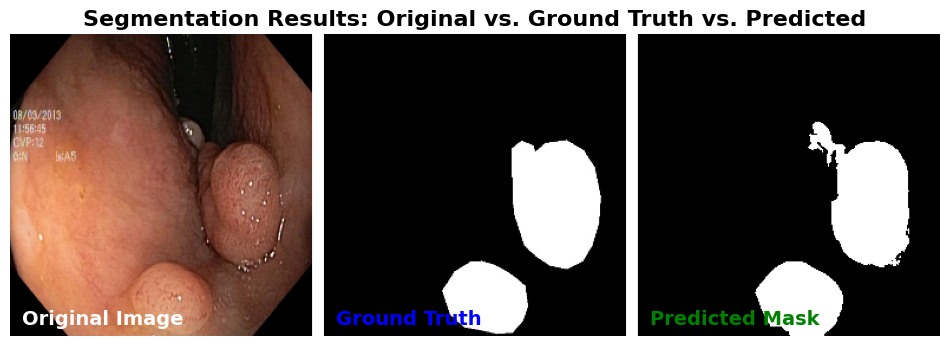

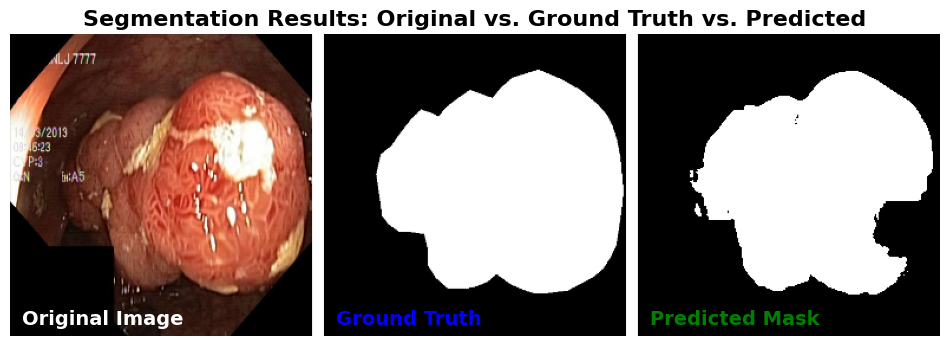

In [55]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with 3 subplots
fig = make_subplots(rows=1, cols=3, subplot_titles=["Original Image", "Ground Truth", "Predicted Mask"])

for i, (x, y) in enumerate(zip(test_x[39:49], test_y[39:49])):
    x = read_image(x)
    y = read_mask(y)

    x = x.unsqueeze(0).to("cuda")
    model.to("cuda")

    with torch.no_grad():
        y_pred = model(x).cpu().squeeze() > 0.5

    parsed_y = mask_parse(y)
    parsed_y_pred = mask_parse(y_pred)

    x = x.squeeze().permute(1, 2, 0).cpu().numpy()
    parsed_y = parsed_y.cpu().numpy()
    parsed_y_pred = parsed_y_pred.cpu().numpy()

    fig.add_trace(go.Image(z=x), row=1, col=1)  # Original Image
    fig.add_trace(go.Image(z=parsed_y), row=1, col=2)  # Ground Truth
    fig.add_trace(go.Image(z=parsed_y_pred), row=1, col=3)  # Predicted Mask

# Update layout for better presentation
fig.update_layout(
    title="Segmentation Results: Original vs. Ground Truth vs. Predicted",
    template="plotly_dark",
    width=1000, height=400,
    showlegend=False
)

# Show interactive plot
fig.show()


In [56]:
# Define the path where the model will be saved
model_path = "unet_model.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

print(f"Model saved successfully at {model_path}")

Model saved successfully at unet_model.pth


In [ ]:
# Load the model's state dictionary
model.load_state_dict(torch.load(model_path))
model.to(DEVICE)
model.eval()  # Set model to evaluation mode

print("Model loaded successfully!")